In [1]:
from PIL import Image
import numpy as np
import torch
from diffusers import DiffusionPipeline, LMSDiscreteScheduler, DDIMScheduler

from inference import (
    draw_box,
    per_box_image,
    per_image_latents,
    compose_latents,
    generate
)

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Example

In [3]:
example = {
    "prompt": "A realistic outdoor image of a plane taking off over a house at sunset.",
    "objects": "a plane; a house",
    "bboxes": [[[0.1, 0.25, 0.5, 0.75]], [[0.5, 0.6, 1, 1]]], # x1, y1, x2, y2
    "description": "A realistic outdoor image at sunset"
}

### Per-Box Image Generation with Associated Cross-Attention Mask

In [4]:
noise_scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012,
                                           beta_schedule="scaled_linear", num_train_timesteps=1000)

pipeline = DiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", scheduler=noise_scheduler).to(device)
tokenizer = pipeline.tokenizer

unet\diffusion_pytorch_model.safetensors not found
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Generating image for box 1 with caption: A realistic outdoor image at sunset with a plane


  0%|          | 0/50 [00:00<?, ?it/s]

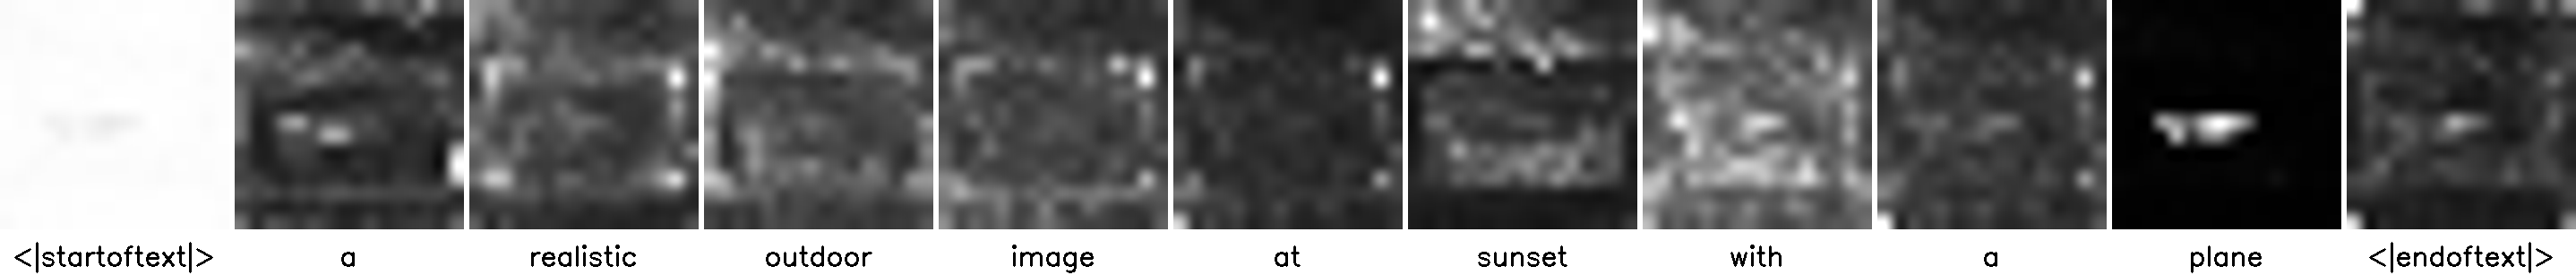

Generating image for box 2 with caption: A realistic outdoor image at sunset with a house


  0%|          | 0/50 [00:00<?, ?it/s]

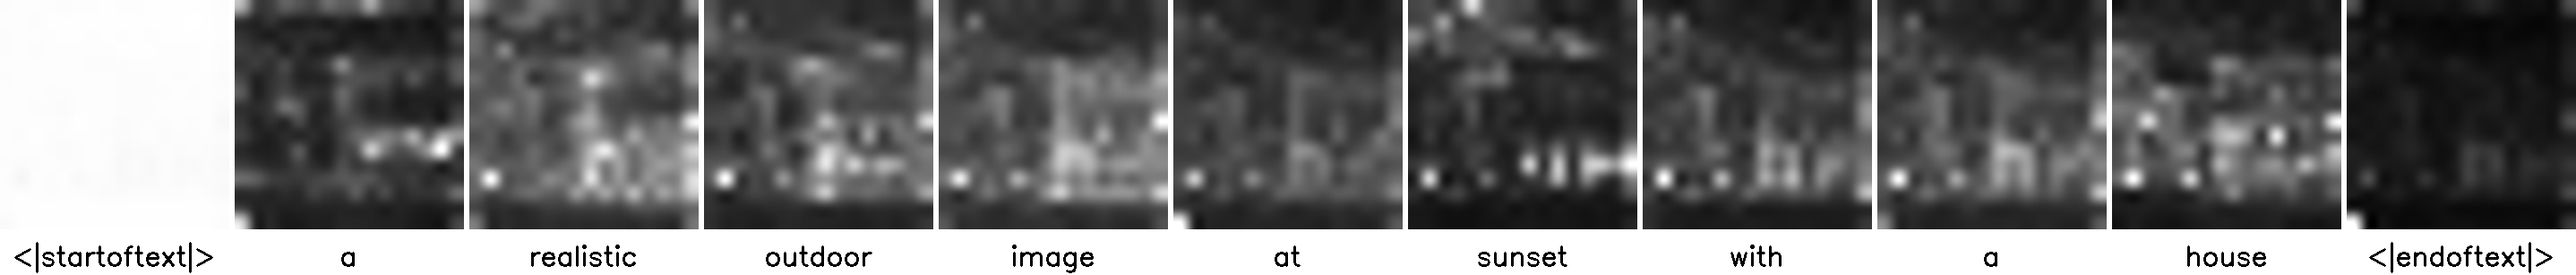

In [5]:
pil_images = []
obj_masks = []

for obj_idx, phrase in enumerate(example['objects'].split(";")):
    print(f"Generating image for box {obj_idx+1} with caption: {example['description'].strip('.').strip()} with {phrase.strip()}")
    image, mask = per_box_image(
        model=pipeline,
        box_prompt=phrase.strip(),
        background_prompt=example['description'].strip('.').strip(),
        bbox=example['bboxes'][obj_idx],
        from_where=["up", "mid"],
        height=512,
        width=512,
        timesteps=50,
        loss_scale=30,
        guidance_scale=7.5,
        seed=0,
        show_xattn=True
    )

    pil_images.append(image)
    obj_masks.append(mask)

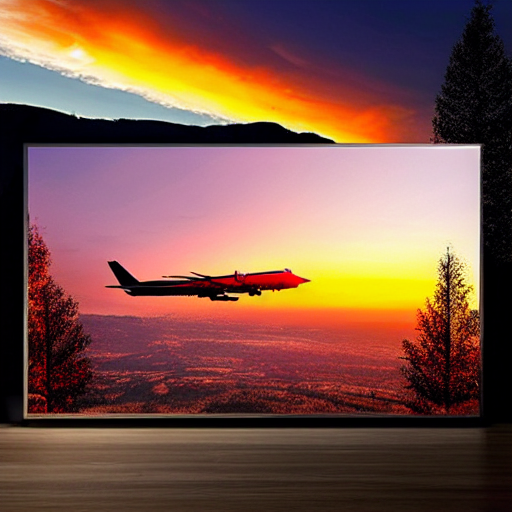

In [10]:
display(pil_images[0])

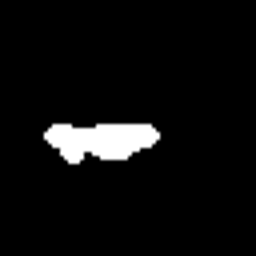

In [11]:
mask = obj_masks[0][0, 0]
mask = 255 * mask / mask.max()
mask = mask.unsqueeze(-1).expand(*mask.shape, 3)
mask = mask.numpy().astype(np.uint8)
display(Image.fromarray(mask).resize((256, 256)))

### Per Image Latents via DDIM Inversion

In [12]:
noise_scheduler = DDIMScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    num_train_timesteps=1000,
    clip_sample=False,
    steps_offset=1
)

pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", scheduler=noise_scheduler).to(device)

unet\diffusion_pytorch_model.safetensors not found
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [13]:
inverse_latents = []

for im in pil_images:
    inverse_latents.append(per_image_latents(pipeline, im))

In [14]:
inverse_latents[0].size(), obj_masks[0].size()

(torch.Size([1, 4, 64, 64]), torch.Size([1, 1, 64, 64]))

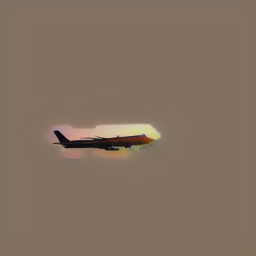

In [15]:
masked_latents = inverse_latents[0] * obj_masks[0].to(device)
masked_latents = 1 / 0.18215 * masked_latents.detach()
image = pipeline.vae.decode(masked_latents)['sample'].detach()
image = (image / 2 + 0.5).clamp(0, 1)
image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
image = (image * 255).astype(np.uint8)
display(Image.fromarray(image).resize((256, 256)))

### Compose Latents with Masks

In [16]:
composed_latents, foreground_mask = compose_latents(
    pipeline,
    inverse_latents,
    obj_masks,
    height=512,
    width=512,
    seed=13
)

### Generate Final Output

In [17]:
composed_prompt = example['description'].strip('.').strip() + " with "
for phrase in example['objects'].split(";"):
    composed_prompt += phrase.strip() + " and "
composed_prompt = composed_prompt.strip(" and ")

print("Composed prompt:", composed_prompt)

output_pil_images = generate(
    model=pipeline,
    latents=composed_latents,
    prompt=composed_prompt,
    foreground_mask=foreground_mask,
    foreground_ratio=0.4,
    inference_steps=50,
    guidance_scale=7.5
)

Composed prompt: A realistic outdoor image at sunset with a plane and a house


  0%|          | 0/50 [00:00<?, ?it/s]

In [18]:
draw_box(output_pil_images[0], example['bboxes'], example['objects'], "test.png")

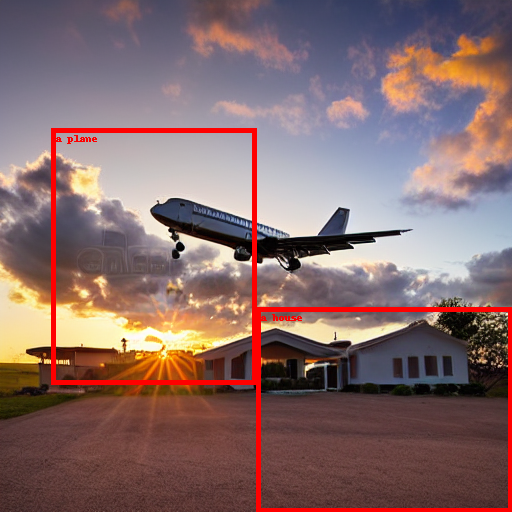

In [19]:
display(Image.open('test.png'))